# Plane CV 

The goal here is to try to establish flying speed from camera images. 

The grand idea is to: 
- identify plane
- determine its specs (wingspan etc) 
- measure the increase in wingspan over time
- calculate and display speed on the video

![early notes](img/planeCV.jpg)


# Unity simulation
- plane models 
- jitter images to create a large data set 
- train a deep model to recognize planes 
- randomly generate planes to come down the runway
- random speeds within a plausible range 
- in game camera detects plane
- then identifies it and begins to calculate the speed based on pixels 
- then tracks it (using skillz from udacity) 

# Processing each image

In [61]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import cv2
import glob
from skimage.feature import hog
from skimage import color, exposure
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import scipy
import collections

In [2]:
# getting a couple of frames from a subclip for some analysis
clip1 = VideoFileClip("baron_beacon_approach.mp4")

# making a smaller subclip for time sake
# test_clip = clip1.subclip(10,15)

test_clip.save_frame("frame1.png") # saves the first frame
test_clip.save_frame("frame2.png", t=5) # saves the frame a t=2s

NameError: name 'VideoFileClip' is not defined

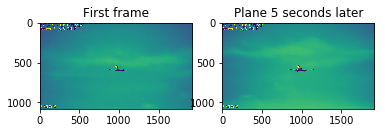

In [100]:
# plotting the two images 
# Plot the examples
frame1 = cv2.imread("frame1.png",0)
frame2 = cv2.imread("frame2.png",0)

fig = plt.figure()
plt.subplot(121)
plt.imshow(frame1)
plt.title('First frame')
plt.subplot(122)
plt.imshow(frame2)
plt.title('Plane 5 seconds later')
plt.savefig('Plane_5_seconds.png',transparent=True)

In [101]:
frame1.shape

(1080, 1920)

In [102]:
frame1

array([[ 68,  68,  70, ...,  68,  68,  68],
       [ 68,  68,  68, ...,  70,  68,  68],
       [ 68,  68,  67, ...,  70,  68,  68],
       ..., 
       [ 92,  92,  93, ..., 109, 108, 108],
       [ 92,  93,  93, ..., 109, 110, 110],
       [ 92,  94,  94, ..., 110, 111, 111]], dtype=uint8)

In [103]:
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [115]:
# so what I am starting with is simply a measurement from one frame to the next
# divided by delta t to get a sort of velocity measurement

# 1. convert to gray
# 2. gaussian blur
# 3. sobel gradients and binary image
# 4. canny
# 5. findCountours



# gray = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(frame1,(7,7),0)

# edges = cv2.Canny(frame1, 50, 100)

sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 3)

abs_sobel_x = np.absolute(sobel_x)
abs_sobel_y = np.absolute(sobel_y)

scaled_sobel_x = np.uint8(255*abs_sobel_x / np.max(abs_sobel_x))
scaled_sobel_y = np.uint8(255*abs_sobel_y / np.max(abs_sobel_y))


thresh = (10,255)
sx_binary = np.zeros_like(scaled_sobel_x)
sx_binary[(scaled_sobel_x >= thresh[0]) & (scaled_sobel_x <= thresh[1])] = 1  

sy_binary = np.zeros_like(scaled_sobel_y)
sy_binary[(scaled_sobel_y >= thresh[0]) & (scaled_sobel_y <= thresh[1])] = 1

# Combine the two binary thresholds
combined_binary = np.zeros_like(sx_binary)
combined_binary[(sx_binary == 1) | (sx_binary == 1)] = 1


vertices = np.array([[(0,200),(1920, 200), (1920,1000), (0,1000)]], dtype=np.int32) # also this works without "dtype"
roi = region_of_interest(combined_binary, vertices)

roi = cv2.dilate(roi, None, iterations=10)
roi = cv2.erode(roi, None, iterations=10)

blob = roi # saving out the dialated and erode image for visualization

ret,thresh = cv2.threshold(roi,0,255,0)
im2,contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for c in contours:

    # # getting the bounding box
    x,y,w,h = cv2.boundingRect(c)
    if w > 50:
        roi = cv2.rectangle(frame1,(x,y),(x+w,y+h),(0,0,255),2)


In [167]:
x_offset = 200
y_offset = 200
img_size = (gray.shape[1], gray.shape[0])

src = np.float32([(922,542), (1013,546), (1123,589), (855,580)]) 
dst = np.float32([[900, 400], 
                  [1000, 400], 
                  [1000,800], 
                  [900, 800]])


M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src) # used later to lay the the polynomials back into the image

warped = cv2.warpPerspective(gray, M, img_size)


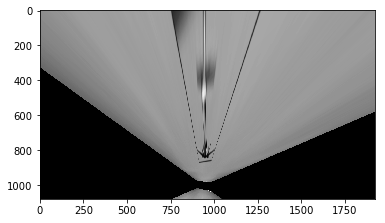

In [168]:
plt.imshow(warped, cmap="gray")

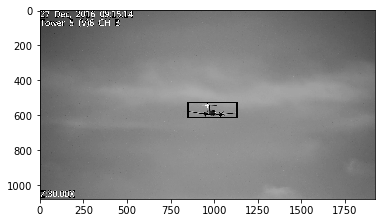

In [143]:
plt.imshow(roi, cmap="gray")

## Final image processing function

In [ ]:
#printing the text things 
cv2.putText(processed_image,"Left curve radius: "+ str(round(left_curverad)) , (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (238,232,170), 3)
cv2.putText(processed_image,"Right curve radius: "+ str(round(right_curverad)) , (850,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (238,232,170), 3)
cv2.putText(processed_image,"Meters off center", (530,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (238,232,170), 3)
cv2.putText(processed_image,str(round(meters_off_center, 2)) , (640,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (238,232,170), 3)

cv2.imwrite('/home/deep_cat/sdc-P4/test_images/'+ 'final_single.jpg',cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.imshow(processed_image)


In [134]:
widths = collections.deque(maxlen=10)

def process_frame(frame):
    
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray,(7,7),0)

   

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 3)

    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)

    scaled_sobel_x = np.uint8(255*abs_sobel_x / np.max(abs_sobel_x))
    scaled_sobel_y = np.uint8(255*abs_sobel_y / np.max(abs_sobel_y))


    thresh = (10,255)
    sx_binary = np.zeros_like(scaled_sobel_x)
    sx_binary[(scaled_sobel_x >= thresh[0]) & (scaled_sobel_x <= thresh[1])] = 1  

    sy_binary = np.zeros_like(scaled_sobel_y)
    sy_binary[(scaled_sobel_y >= thresh[0]) & (scaled_sobel_y <= thresh[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(sx_binary == 1) | (sx_binary == 1)] = 1


    vertices = np.array([[(0,200),(1920, 200), (1920,1000), (0,1000)]], dtype=np.int32) # also this works without "dtype"
    roi = region_of_interest(combined_binary, vertices)

    roi = cv2.dilate(roi, None, iterations=10)
    roi = cv2.erode(roi, None, iterations=10)
    
    # for visualization purposes
    blob_gray = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY)[1]
    blob3 = cv2.cvtColor(blob_gray,cv2.COLOR_GRAY2RGB)
    
#     # 
#     ret,thresh = cv2.threshold(roi,0,255,0)
#     im2,contours,hierarchy = cv2.findContours(thresh, 1, 2)
#     cnt = contours[0]


#     # # getting the bounding box
#     x,y,w,h = cv2.boundingRect(cnt)
#     roi = cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
    
    
    ret,thresh = cv2.threshold(roi,0,255,0)
    im2,contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_w = 0
    for c in contours:
        
        # # getting the bounding box
        x,y,w,h = cv2.boundingRect(c)
        roi = cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
        if w > max_w:
            max_w = w
            
    widths.append(max_w)    
    cv2.putText(roi,"width: "+ str(round(max_w)) , (800,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (238,232,170), 3)
    cv2.putText(roi,"width: "+ str(round(np.mean(widths))) , (800,250), cv2.FONT_HERSHEY_SIMPLEX, 2, (238,232,170), 3)
        
    bigScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
    bigScreen[0:540, 0:960] = cv2.resize(roi, (960,540), interpolation=cv2.INTER_AREA) 
    
    cv2.putText(blob3, 'Dialated and Eroded Binary Image', (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 2)
    bigScreen[0:540, 960:1920] = cv2.resize(blob3, (960,540), interpolation=cv2.INTER_AREA) 
    
    return bigScreen

# Processing the Video 

In [135]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [136]:
# running the pipeline on the video
# output_name = 'project_video_output_newprocess.mp4'
# clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("sub_clip.mp4")

# making a smaller subclip for time sake
# test_clip = clip1.subclip(10,15)
# test_clip.write_videofile('sub_clip.mp4', audio= False)

output_clip = clip1.fl_image(process_frame)
output_clip.write_videofile('test_output.mp4', audio= False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 99%|█████████▉| 150/151 [00:21<00:00,  7.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 



# References
Websites:
http://www.pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/

http://photo.stackexchange.com/questions/12434/how-do-i-calculate-the-distance-of-an-object-in-a-photo


not sure this is useful: http://www.bdimitrov.de/kmp/technology/fov.html
http://www.jairobinson.com/blog/game-art/matching-fov-between-blender-3d-and-unity/
https://docs.unity3d.com/Manual/FrustumSizeAtDistance.html


Various Docs (for future reference):
https://zulko.github.io/moviepy/getting_started/efficient_moviepy.html

http://www.scantips.com/lights/fieldofview.html#top
http://www.pyimagesearch.com/2015/02/09/removing-contours-image-using-python-opencv/

https://pythonprogramming.net/mog-background-reduction-python-opencv-tutorial/
http://docs.opencv.org/trunk/db/d5c/tutorial_py_bg_subtraction.html

https://www.youtube.com/watch?v=88HdqNDQsEk&index=16&list=PLQVvvaa0QuDdttJXlLtAJxJetJcqmqlQq

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html#lucas-kanade

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_table_of_contents_video/py_table_of_contents_video.html

http://personal.ee.surrey.ac.uk/Personal/R.Bowden/publications/avbs01/avbs01.pdf

http://docs.opencv.org/trunk/db/d5c/tutorial_py_bg_subtraction.html




In [ ]:
# some helper stuff for visualization



# middle panel text example
# using cv2 for drawing text in diagnostic pipeline.
font = cv2.FONT_HERSHEY_COMPLEX
middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
cv2.putText(middlepanel, 'Estimated lane curvature: ERROR!', (30, 60), font, 1, (255,0,0), 2)
cv2.putText(middlepanel, 'Estimated Meters right of center: ERROR!', (30, 90), font, 1, (255,0,0), 2)


# assemble the screen example
diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
diagScreen[0:720, 0:1280] = mainDiagScreen
diagScreen[0:240, 1280:1600] = cv2.resize(diag1, (320,240), interpolation=cv2.INTER_AREA) 
diagScreen[0:240, 1600:1920] = cv2.resize(diag2, (320,240), interpolation=cv2.INTER_AREA)
diagScreen[240:480, 1280:1600] = cv2.resize(diag3, (320,240), interpolation=cv2.INTER_AREA)
diagScreen[240:480, 1600:1920] = cv2.resize(diag4, (320,240), interpolation=cv2.INTER_AREA)*4
diagScreen[600:1080, 1280:1920] = cv2.resize(diag7, (640,480), interpolation=cv2.INTER_AREA)*4
diagScreen[720:840, 0:1280] = middlepanel
diagScreen[840:1080, 0:320] = cv2.resize(diag5, (320,240), interpolation=cv2.INTER_AREA)
diagScreen[840:1080, 320:640] = cv2.resize(diag6, (320,240), interpolation=cv2.INTER_AREA)
diagScreen[840:1080, 640:960] = cv2.resize(diag9, (320,240), interpolation=cv2.INTER_AREA)
diagScreen[840:1080, 960:1280] = cv2.resize(diag8, (320,240), interpolation=cv2.INTER_AREA)

